In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist

In [3]:
def kernel(x1, x2, var_f, l):
    """Squared exponential kernel"""
    return var_f * np.exp((-cdist(x1, x2)**2) / (2*l**2))

In [4]:
n = 100  # number of test points
x_min = -5
x_max = 5
x_star = np.linspace(x_min*1.4, x_max*1.4, n).reshape(-1,1) # points we're going to make predictions at

In [5]:
jitter = 1e-10  # small number to ensure numerical stability (eigenvalues of K can decay rapidly)
def sample(mu, var, epsilon, N):
    """Generate N samples from a multivariate Gaussian \mathcal{N}(mu, var)"""
    L = np.linalg.cholesky(var + jitter*np.eye(var.shape[0])) # cholesky decomposition (square root) of covariance matrix
    f_post = mu + L @ np.random.normal(size=(n, N))
    return f_post

In [6]:
l = 1 # lengthscale hyper-parameter
var_f = 1  # signal variance hyper-parameter
m = 3 # mean of the model
Kss = kernel(x_star, x_star, var_f, l)  # prior covariance

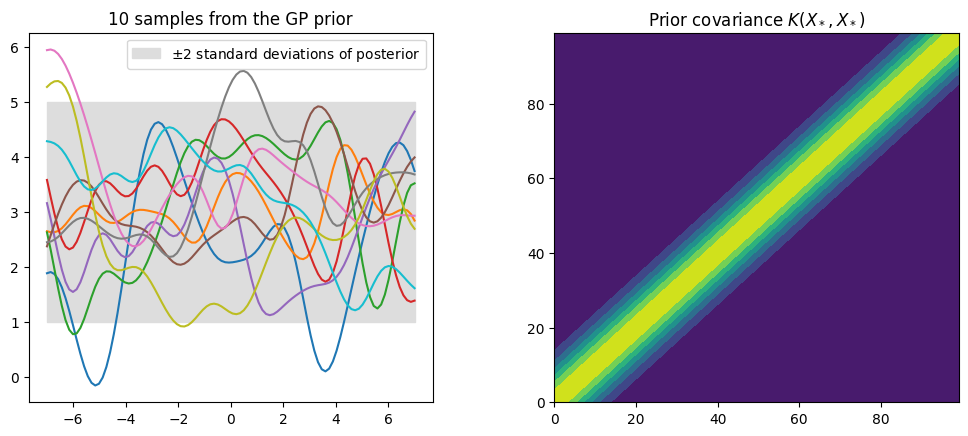

In [8]:
# draw samples from the prior
Ns = 10 # number of samples
f_prior = sample(m, Kss, jitter, N=10)
#f_prior = sample(0, Kss, jitter, N=10)

# compute standard deviation for plotting
std = np.sqrt(np.diag(Kss))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# plot the sampled values as functions of x_star
plt.subplot(2, 2, 1)
plt.plot(x_star, f_prior)
plt.title('%i samples from the GP prior' % Ns)
plt.fill_between(x_star.flatten(), m-2*std, m+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
plt.legend()

# visualise the covariance function
plt.subplot(2, 2, 2)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)
plt.show()

In [108]:

f = lambda x: np.sin(x) + 0.1*np.cos(2*x) + 5 # underlying function

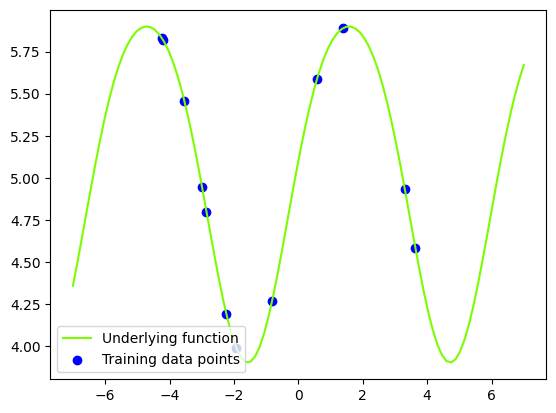

In [109]:
N = 12  # number of training points
x_train = np.random.uniform(x_min, x_max, size=(N, 1))  # training inputs
# x_train = np.linspace(x_min, x_max, N).reshape(N, 1)  # training inputs
y_train = f(x_train)  # training outputs (f) - these are noise free observations of the underlying function f

# plt.title('Underlying function $f(x)=sin(x)$ and dummy data set ')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

In [110]:
def gp_regression(X, y, k, x_star, s_f, l, mx):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, s_f, l))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, (y - mx)))
    mu = mx + k(X, x_star, s_f, l).T @ a

    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    var = k(x_star, x_star, s_f, l) - v.T @ v

    return mu, var

In [111]:
l = 1 # lengthscale
var_f = 1  # signal variance
mu, var = gp_regression(x_train, y_train, kernel, x_star, var_f, l, m)

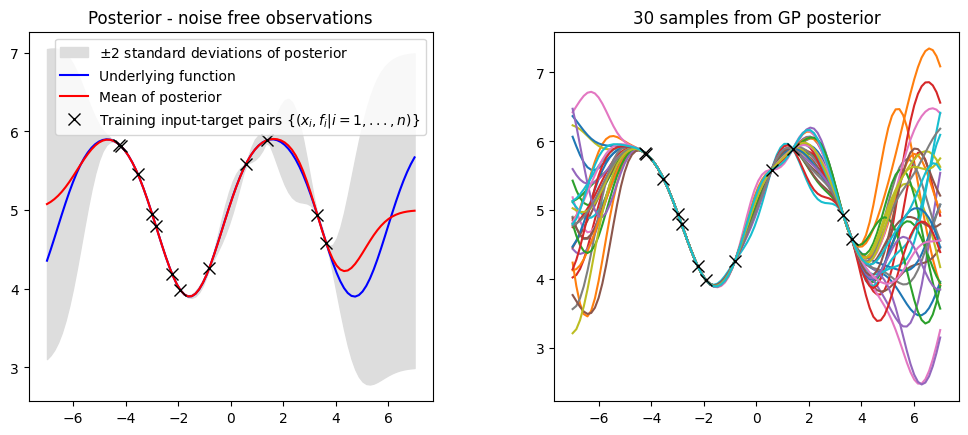

In [112]:
def plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="GP posterior"):
    std = np.sqrt(np.diag(var))  # square root the variance to get standard deviation
    f_post = sample(mu, var, jitter, N=num_samples)  # draw samples from posterior

    fig = plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # plot underlying function, training data, posterior mean and +/- 2 standard deviations
    plt.subplot(2, 2, 1)
    plt.title(title)
    plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
    plt.plot(x_star, f(x_star), 'b-', label='Underlying function')
    plt.plot(x_star, mu, 'r-', label='Mean of posterior')  # plot mean of posterior
    plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
    plt.legend()

    # plot samples from posterior
    plt.subplot(2, 2, 2)
    plt.title('%i samples from GP posterior' % num_samples)
    plt.plot(x_star, f_post)  # plot samples from posterior
    plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, y_i | i = 1,...,n)\}$')
    plt.show()

plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - noise free observations")

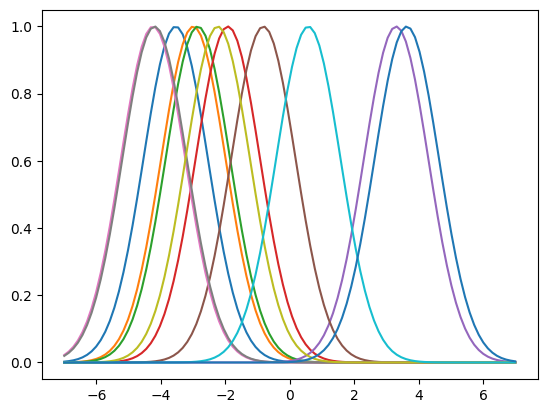

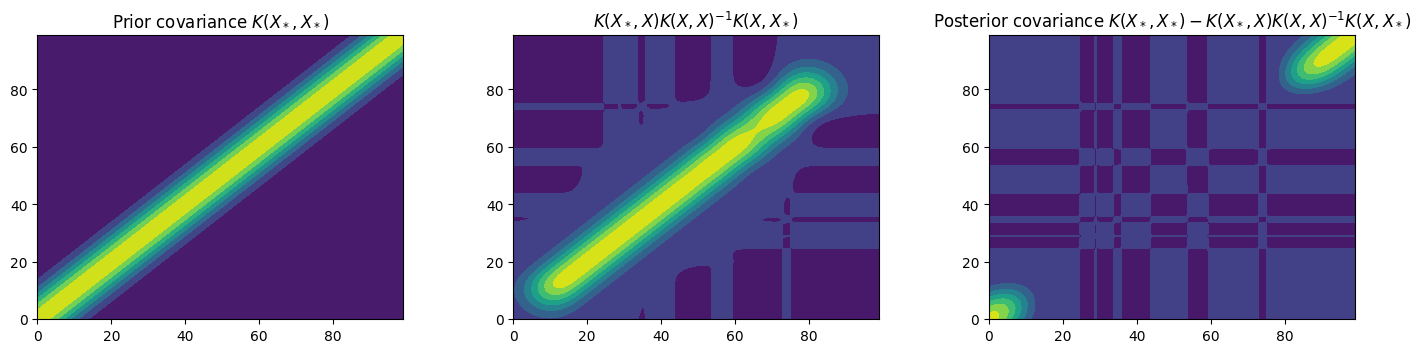

In [113]:
kk = kernel(x_star, x_train, var_f, l) @ np.linalg.inv(kernel(x_train, x_train, var_f, l)) @ kernel(x_train, x_star, var_f, l)
b = kernel(x_train,x_star,var_f,l)
for i in range(11):
    plt.plot(x_star, b[i, :])

plt.show()

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(3, 3, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)

plt.subplot(3, 3, 2)
plt.title("$K(X_*, X) K(X, X)^{-1} K(X, X_*)$")  # TODO: This represents the effect of the likelihood but can it be called the likelihood covariance???
plt.contourf(kk)

plt.subplot(3, 3, 3)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(var)
plt.show()

In [208]:
y = lambda x, s: f(x) + np.random.normal(0, np.sqrt(s), x.shape) # generate noisy observations

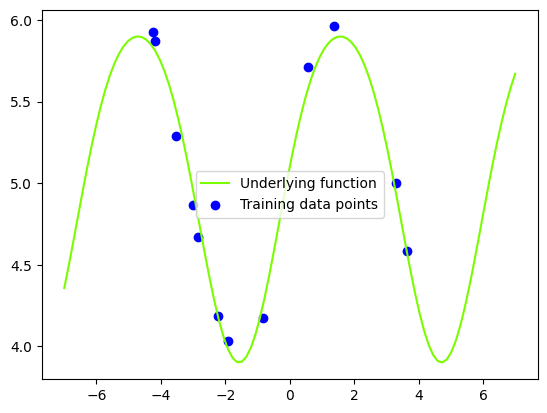

In [209]:
s_n_gen = 0.01  # noise variance
y_train = y(x_train, s_n_gen)  # observed target values (y)

# plt.title('Sinusoidal data set')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

In [210]:
def gp_regression_noisy(X, y, k, x_star, var_f, var_n, l, mx):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, var_f, l) + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, (y - mx)))
    mu = mx + k(X, x_star, var_f, l).T @ a

    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, var_f, l))
    var = k(x_star, x_star, var_f, l) - v.T @ v

    return mu, var

In [211]:
var_f = 1  # signal variance
var_n = 0.1  # noise variance
l = 1  # lengthscale
m = 3 #signal mean

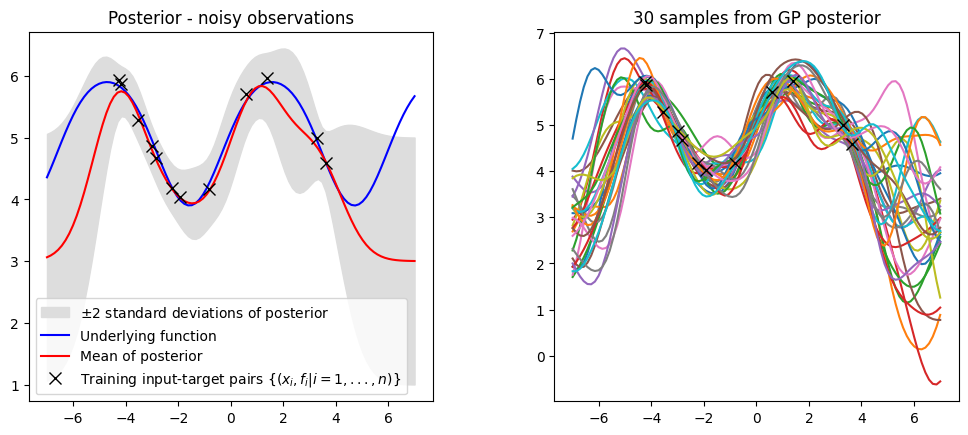

In [212]:
mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, var_f, var_n, l , m)
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - noisy observations")

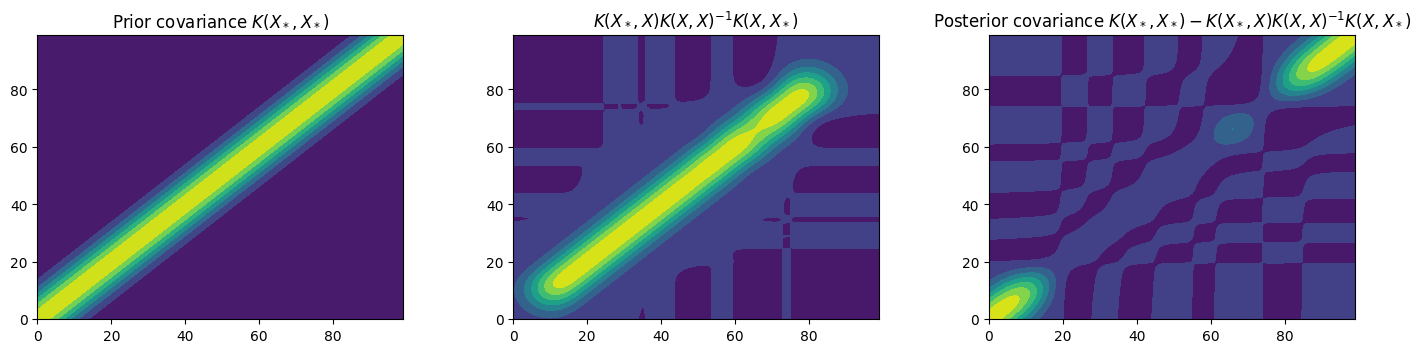

In [213]:


kk = kernel(x_star, x_train, var_f, l) @ np.linalg.inv(kernel(x_train, x_train, var_f, l)) @ kernel(x_train, x_star, var_f, l)

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(3, 3, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)

plt.subplot(3, 3, 2)
plt.title("$K(X_*, X) K(X, X)^{-1} K(X, X_*)$")  # TODO: This represents the effect of the likelihood but can it be called the likelihood covariance???
plt.contourf(kk)

plt.subplot(3, 3, 3)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(var)
plt.show()

In [226]:
def f_opt(x, *args):
    """ Calculates the value of the objective (negative log marginal likelihood) for parameters in *args."""
    X, y, k, x_star = args
    var_f, l, var_n, m = x

    Lxx = np.linalg.cholesky(k(X, X, var_f, l) + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y - m))

    #return -(- 0.5 * y.T @ a - np.log(np.trace(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)
    return -(- 0.5 * (y - m).T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)

In [227]:
def dLdT(a,iKxx, dKdt):
    """
    Calculates the partial derivatives of the marginal likelihood w.r.t. the hyper-parameters
        dKdt: partial derivative of of the covariance function wrt a hyper-parameter
    """
    return 0.5 * np.trace(np.dot((a @ a.T - iKxx), dKdt))


In [228]:

def dLdm(y,iKxx, mx):
    """
    Calculates the partial derivatives of the marginal likelihood w.r.t. the mean m

    """
    return iKxx@(y - mx)

In [229]:
def dKdsf(x1, x2, var_f, l):
    """Gradient of SE kernel wrt the signal variance s_f"""
    return  2*np.sqrt(var_f) * np.exp((-cdist(x1, x2)**2) / (2*l**2))

def dKdL(x1, x2, var_f, l):
    """Gradient of SE kernel wrt the lengthscale l"""
    return var_f**2 * np.exp((-cdist(x1, x2)**2) / (2*l**2)) * (-cdist(x1, x2)**2) / (l**3)

def dKdsn(x1, x2, var_n):
    """Gradient of SE kernel wrt the lengthscale noise variance s_n"""
    return 2 * np.sqrt(np.diag(var_n))

In [230]:
def dfx(x, *args):
    """Calculates the gradients of the objective with respect to signal variance, lengthscale and noise variance"""
    X, y, k, x_star = args
    var_f, l, var_n, m = x

    Kxx = k(X, X, var_f, l)
    Lxx = np.linalg.cholesky(Kxx + var_n*np.eye(X.shape[0]))
    a  = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y - m))

    iKxx = np.linalg.inv(Kxx + var_n*np.eye(X.shape[0]))

    J = np.empty([4,])
    J[0] = dLdT(a, iKxx, dKdsf(X, X, var_f, l)) # gradient for signal variance var_f
    J[1] = dLdT(a, iKxx, dKdL(X, X, var_f, l)) # gradient for lengthscale l
    J[2] = dLdT(a, iKxx, dKdsn(X, X, var_n)) # gradient for noise variance var_n
    J[3] = dLdm(y,iKxx,m) # gradient forsignal mean m
    print(J[3])
    return J

In [231]:
import scipy.optimize as opt
import pprint

bounds = [[0, np.inf], [0, np.inf], [0.0001, np.inf],[0, np.inf] ]  # bound the hyper-parameters to always be positive
args = (x_train, y_train, kernel, x_star)  # arguments used in objective function
#j = dfx
x0 = [1, 1, 0.1, 3]  # initial guess at parameters being optimised [s_f, l, s_n, m]
res = opt.fmin_l_bfgs_b(f_opt, x0, args=args,  approx_grad=True, bounds=bounds)  # call the optimisation algorithm
#print((y - m).T @ a )

<ipython-input-226-1126626250e2>:10: RuntimeWarning: divide by zero encountered in log
  return -(- 0.5 * (y - m).T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)
<ipython-input-226-1126626250e2>:10: RuntimeWarning: invalid value encountered in log
  return -(- 0.5 * (y - m).T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)


In [232]:
var_f = res[0][0] # signal variance
l = res[0][1]  # lengthscale
var_n = res[0][2]  # noise variance
m = res[0][3] # signal mean

print("Signal variance: %.6f\nLengthscale: %.6f\nNoise variance: %.6f\nsignal mean %.6f"%(var_f, l, var_n, m))

Signal variance: 1.964158
Lengthscale: 1.428442
Noise variance: 0.002766
signal mean 5.044582


In [1]:
var_n = 0.01

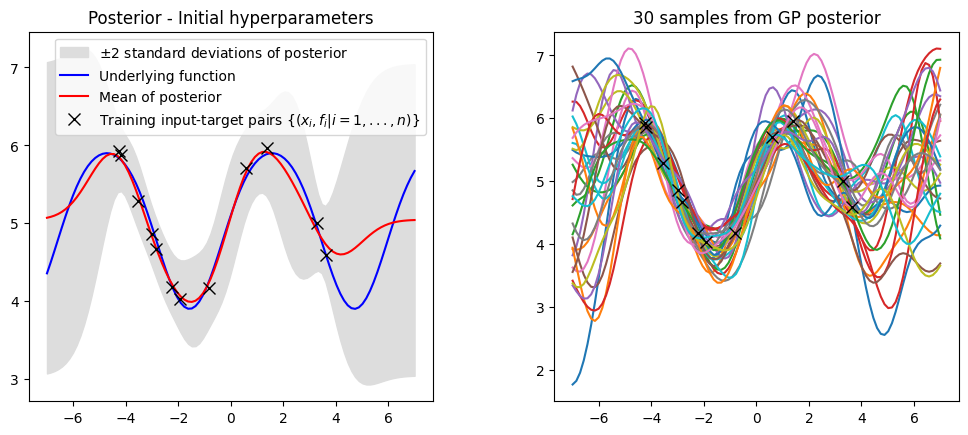

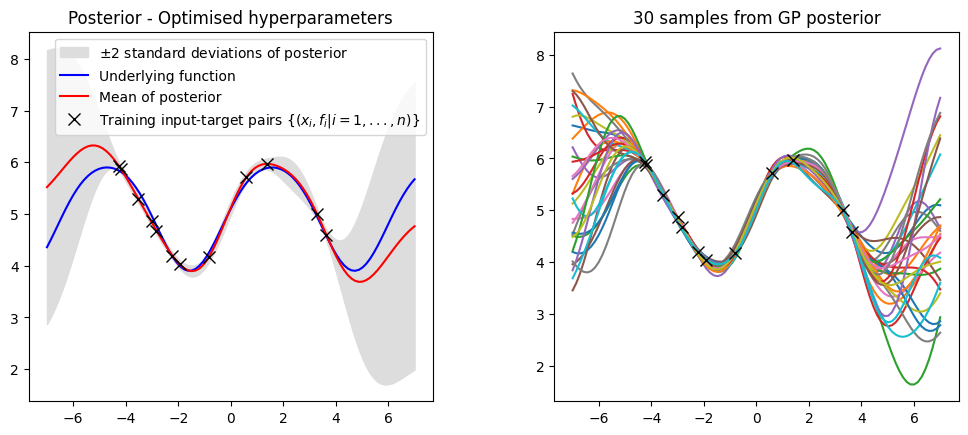

In [233]:
mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, x0[0], x0[2], x0[1], m)
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - Initial hyperparameters")

mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, var_f, var_n, l, m)
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - Optimised hyperparameters")